In [12]:
!pip install xlrd
!pip install xgboost 

In [16]:
import pandas as pd
import numpy as np
from numpy import mean, std, absolute
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, LassoLarsIC, BayesianRidge, PoissonRegressor
import xgboost as xg
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [14]:
data = pd.read_excel('Data/Gasification Data_Daya.xlsx', index_col=0, header=0)
data = data.iloc[1:223,:14] 
display(list(data.columns.values))

# Drop null balues and store dataframe in dataframe 2
data=data.dropna()
print(data)

#Check Null values again after removing
print(data.isnull().values.any())
print(data.isna().values.any())

X = data.iloc[:, :9]
y = data.iloc[:, 9:]

input_columns = list(X.columns.values)
output_columns = list(y.columns.values)

print(X.shape, y.shape)

['C [%wt db]',
 'H [%wt db]',
 'O [%wt db]',
 'Moisture [%wt]',
 'Ash [%wt db]',
 'ER [-]',
 'T [ºC]',
 'Bed material',
 'Steam/Biomass',
 'H2 [%vol N2 free]',
 'CO [%vol N2 free]',
 'CO2 [%vol N2 free]',
 'CH4 [%vol N2 free]',
 'GY [Nm3/kg daf]']

        C [%wt db] H [%wt db]  O [%wt db] Moisture [%wt]  Ash [%wt db]  \
Sr No.                                                                   
2            50.00        5.7       44.10             21          0.85   
3            50.00        5.7       44.10             23          0.85   
4            50.00        5.7       44.10             22          0.85   
5            50.00        5.7       44.10             25          0.85   
6            50.00        5.7       44.10             19          0.85   
...            ...        ...         ...            ...           ...   
219          46.85        6.3       45.55              9          1.30   
220          46.85        6.3       45.55              9          1.30   
221          46.76       5.68       39.46           9.94          8.10   
222          46.76       5.68       39.46           9.94          8.10   
223          46.76       5.68       39.46           9.94          8.10   

        ER [-]  T [ºC]  Bed material 

## Multi-output Regression using Random Forest

In [33]:
methods = ['Linear', 'Ridge', 'LassoLARS', 'Poisson', 'Bayesian', 'RF', 'Bag', 'GradientBoost', 'XGBoost']
number_of_folds = 11
max_depth = 30
kf = KFold(n_splits=number_of_folds, random_state=number_of_folds, shuffle=True)

prediction = {}
error = {}
for met in methods:
    score = {}
    prediction[met] = np.zeros_like(y) 

    for fold, (train, test) in enumerate(kf.split(y)):
        training_x = np.asarray(X)[train]
        testing_x = np.asarray(X)[test]
        training_y = np.asarray(y)[train]
        testing_y = np.asarray(y)[test]
        
        if met == 'Linear':
            regr_multilin = MultiOutputRegressor(LinearRegression())
            regr_multilin.fit(training_x, training_y)
            score[fold] = regr_multilin.predict(testing_x)
            
        elif met == 'Ridge':
            regr_multiridge = MultiOutputRegressor(Ridge(alpha=1000))
            regr_multiridge.fit(training_x, training_y)
            score[fold] = regr_multiridge.predict(testing_x)
            
        elif met == 'LassoLARS':
            regr_multilasso = MultiOutputRegressor(LassoLarsIC())
            regr_multilasso.fit(training_x, training_y)
            score[fold] = regr_multilasso.predict(testing_x)
            
        elif met == 'Poisson':
            regr_multips = MultiOutputRegressor(PoissonRegressor(max_iter=1000))
            regr_multips.fit(training_x, training_y)
            score[fold] = regr_multips.predict(testing_x)
            
        elif met == 'Bayesian':
            regr_multibs = MultiOutputRegressor(BayesianRidge(n_iter=1000))
            regr_multibs.fit(training_x, training_y)
            score[fold] = regr_multibs.predict(testing_x)
            
        elif met == 'RF':
            regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                                  max_depth=max_depth,
                                                                  random_state=0))
            regr_multirf.fit(training_x, training_y)
            score[fold] = regr_multirf.predict(testing_x)
            
        elif met == 'Bag':
            regr_multibag = MultiOutputRegressor(BaggingRegressor(n_estimators=100,
                                                                  random_state=0))
            regr_multibag.fit(training_x, training_y)
            score[fold] = regr_multibag.predict(testing_x)
            
        elif met == 'GradientBoost':
            regr_multigb = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100,
                                                                  random_state=0))
            regr_multigb.fit(training_x, training_y)
            score[fold] = regr_multigb.predict(testing_x)
            
        elif met == 'XGBoost':
            regr_multixg = MultiOutputRegressor(xg.XGBRegressor(objective ='reg:linear', booster='gbtree', eta=0.5, 
                                                                n_estimators = 100, random_state=0))
            regr_multixg.fit(training_x, training_y)
            score[fold] = regr_multixg.predict(testing_x)

    for (train, test), fold in zip(kf.split(y), list(range(number_of_folds))):
        prediction[met][test, :] = score[fold]
    
    error[met] = np.sqrt(mse(y, prediction[met], multioutput='raw_values'))

c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or sc

c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * f

c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in 

c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
c:\users\sauga\google drive\packages\research\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * f

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:1

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:1

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:1

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

c:\users\sauga\google drive\packages\research\lib\site-packages\xgboost\data.py:94: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:17

In [21]:
print(prediction['GradientBoost'])

[[19.53713098 31.91057557 35.21742071  7.84328857  2.29645751]
 [18.83848958 29.95763405 36.05791323  7.22033772  2.62292414]
 [25.49432644 32.96146914 31.30069115  6.97852235  1.60121796]
 [20.46946901 30.85928639 37.22549869  6.94405918  2.41448569]
 [21.75610051 32.83794564 35.33656082  6.82487388  2.20601638]
 [16.19626399 29.85538511 38.1754199   8.25056258  1.91057509]
 [16.52698109 30.72247103 40.12059135  8.22942889  2.19723292]
 [18.3061046  29.69250053 39.37375379  7.88847272  2.32557153]
 [18.09120379 27.23922036 39.26585998  7.90323869  2.32838545]
 [16.71376504 29.59067772 42.66090096  8.24011928  2.72866332]
 [29.22537352 35.57055534 20.7221194   7.57898369  1.74513065]
 [24.48004531 39.1595155  19.65457496  8.42040538  1.86181457]
 [31.89221784 38.55419172 17.82613948  7.60591945  2.39679151]
 [34.48508359 37.13240771 18.55150052  8.08320318  2.59134612]
 [33.33717515 35.64044585 31.61573114  6.22287535  2.60769888]
 [32.12197021 39.57341319 17.50997312  8.26159367  2.38

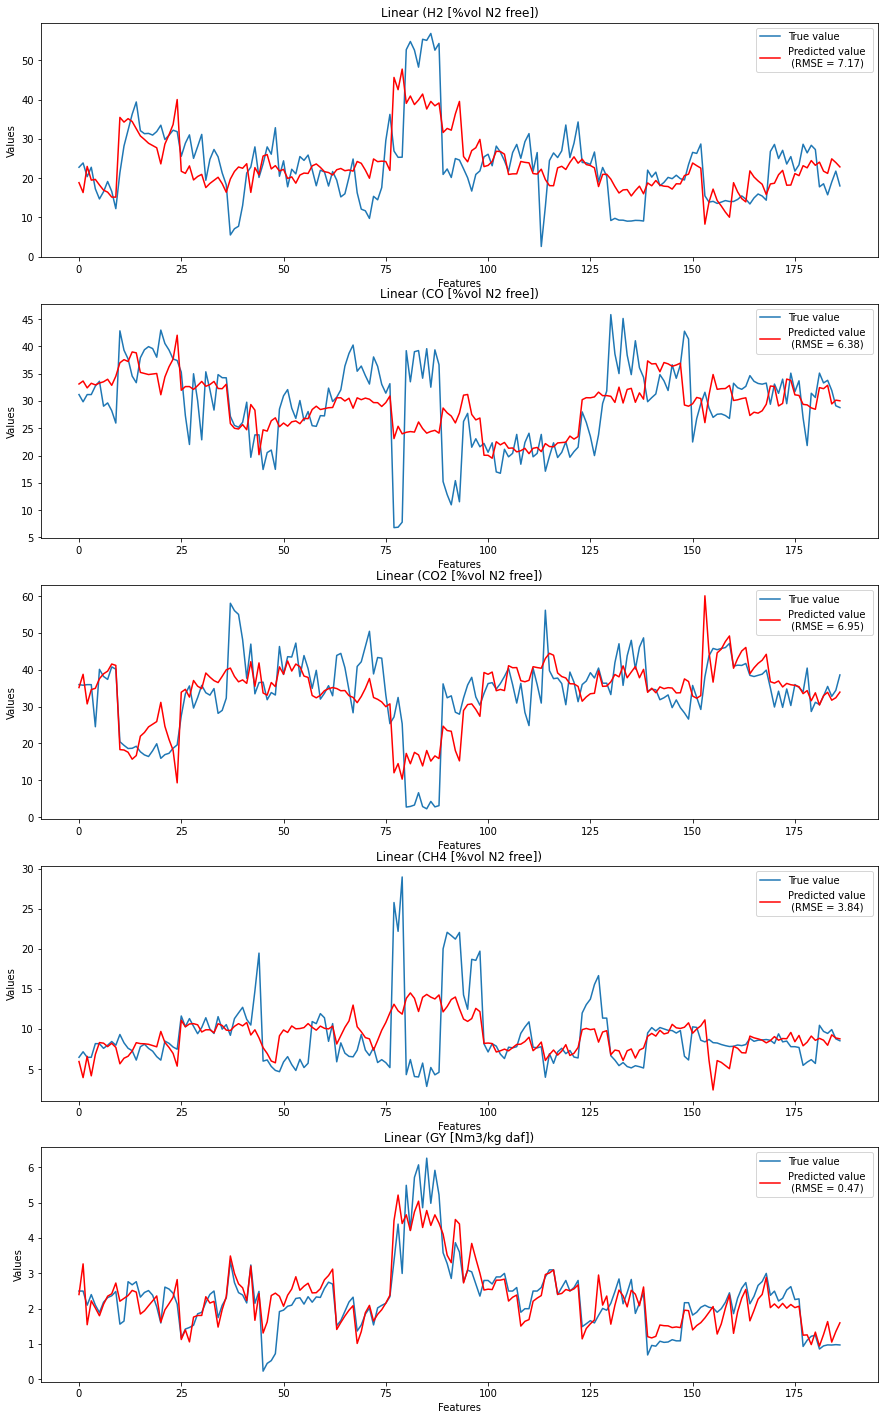

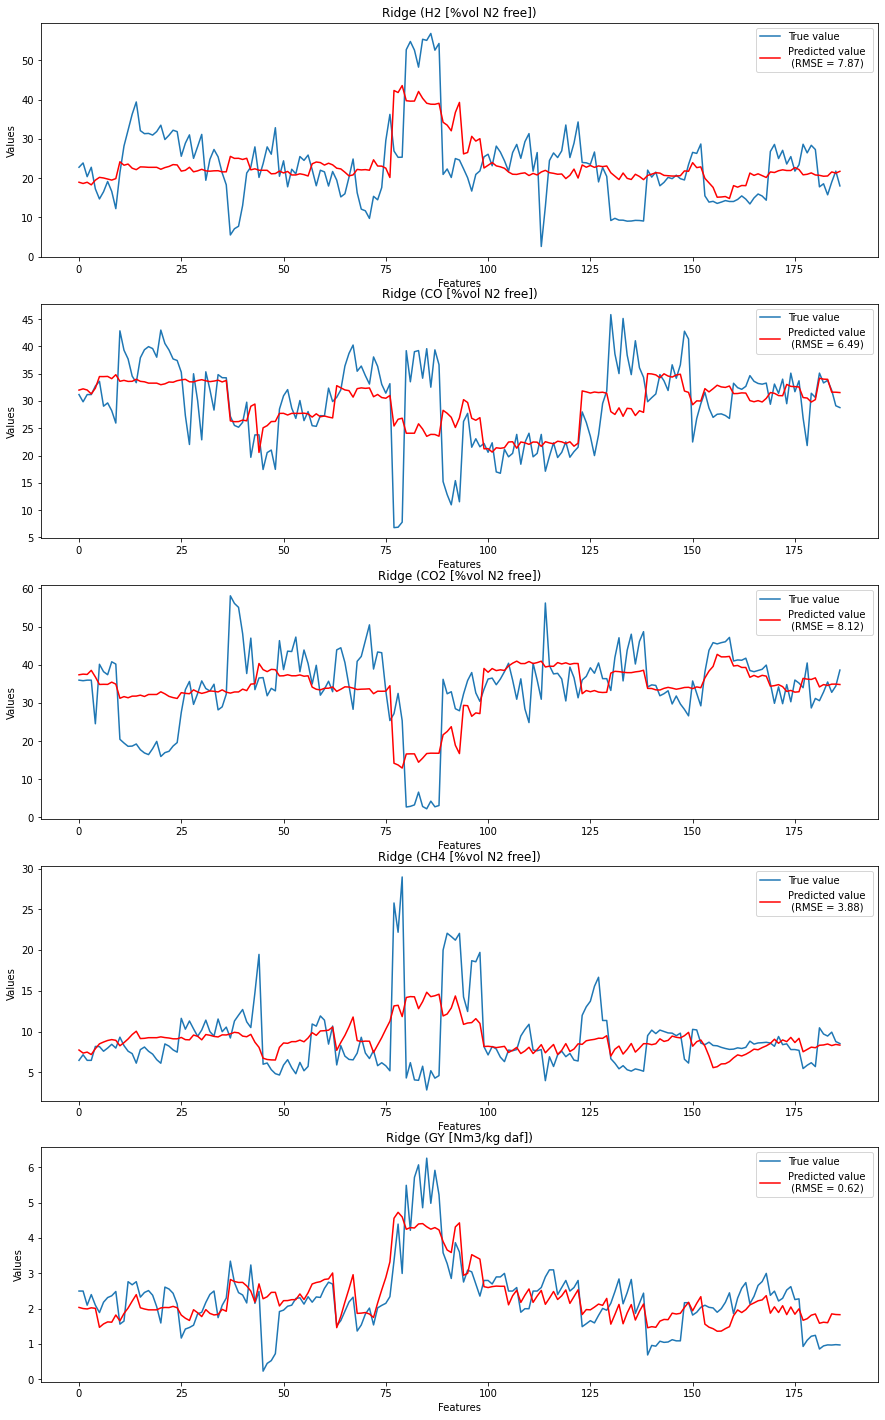

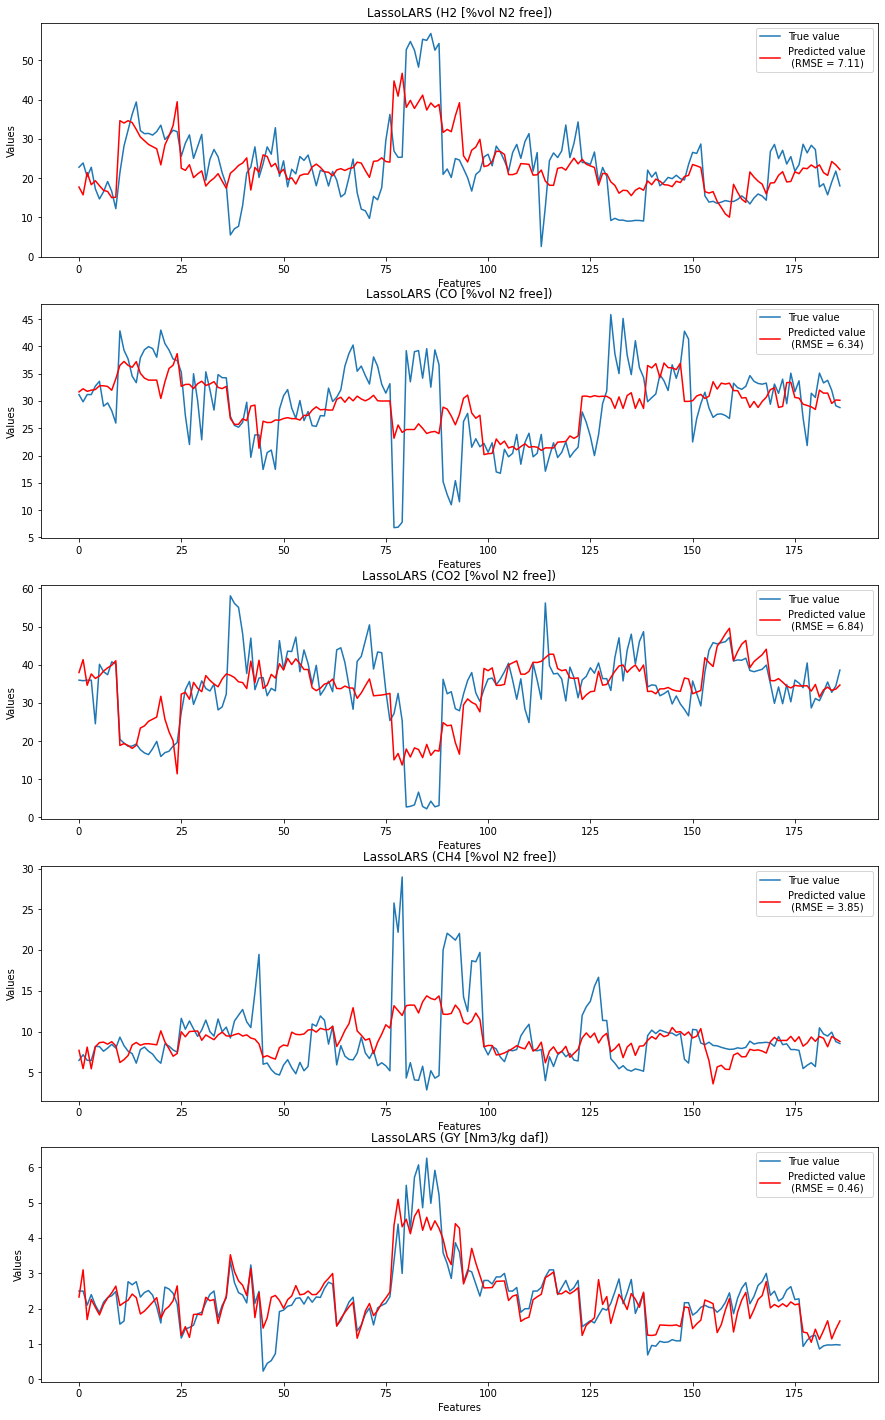

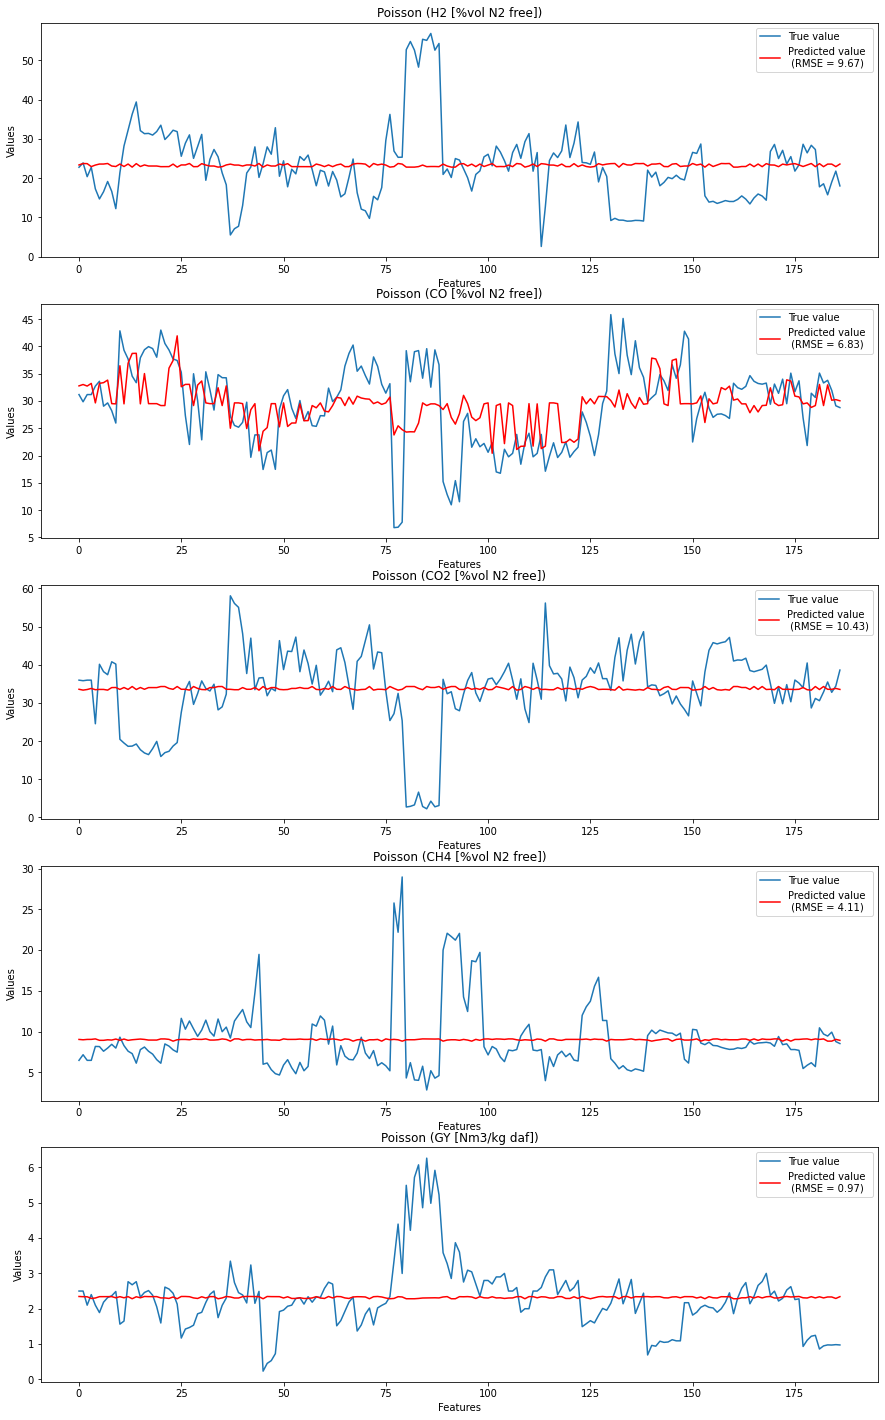

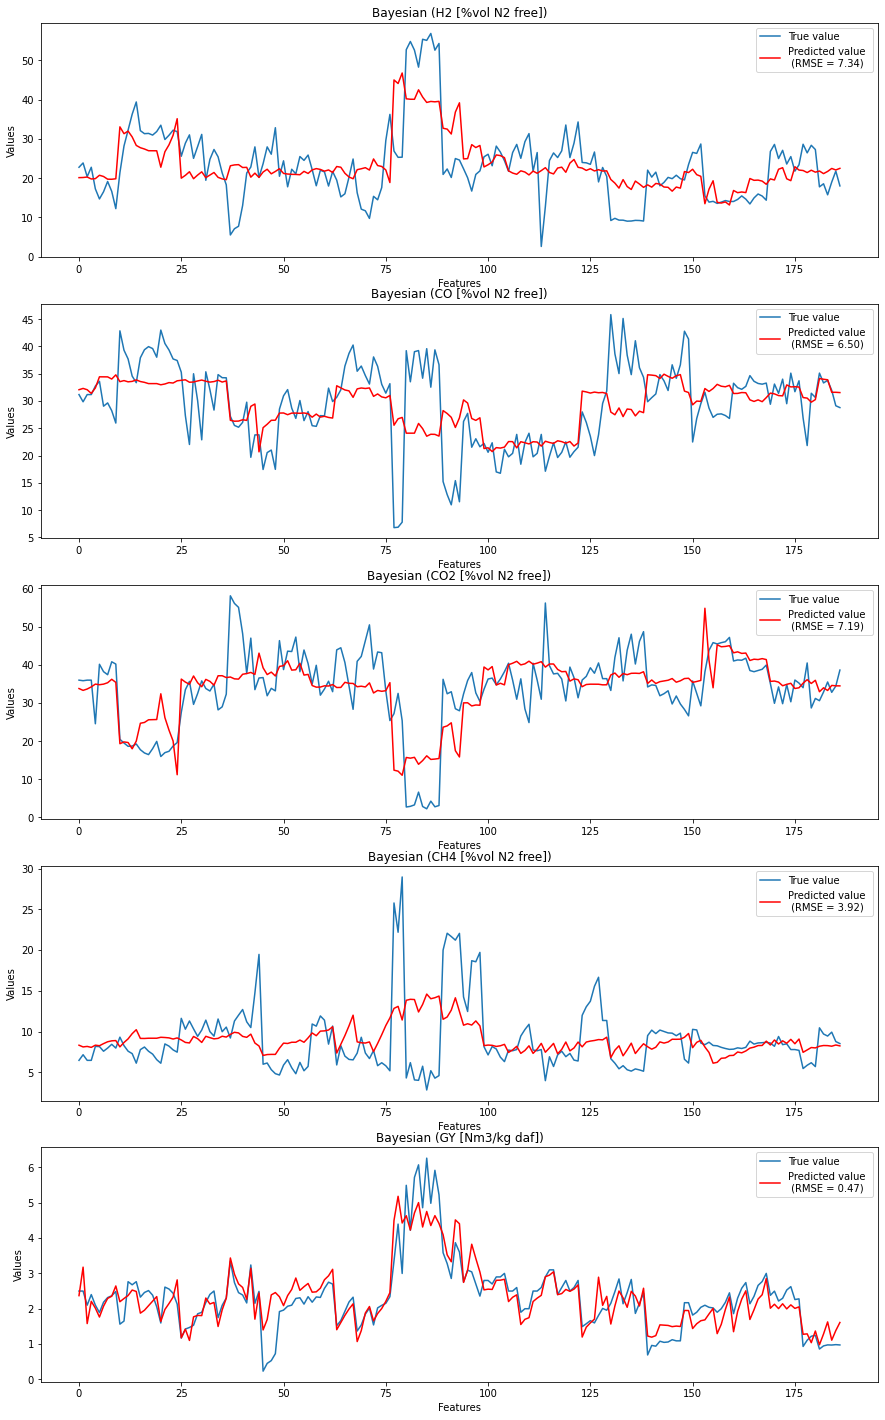

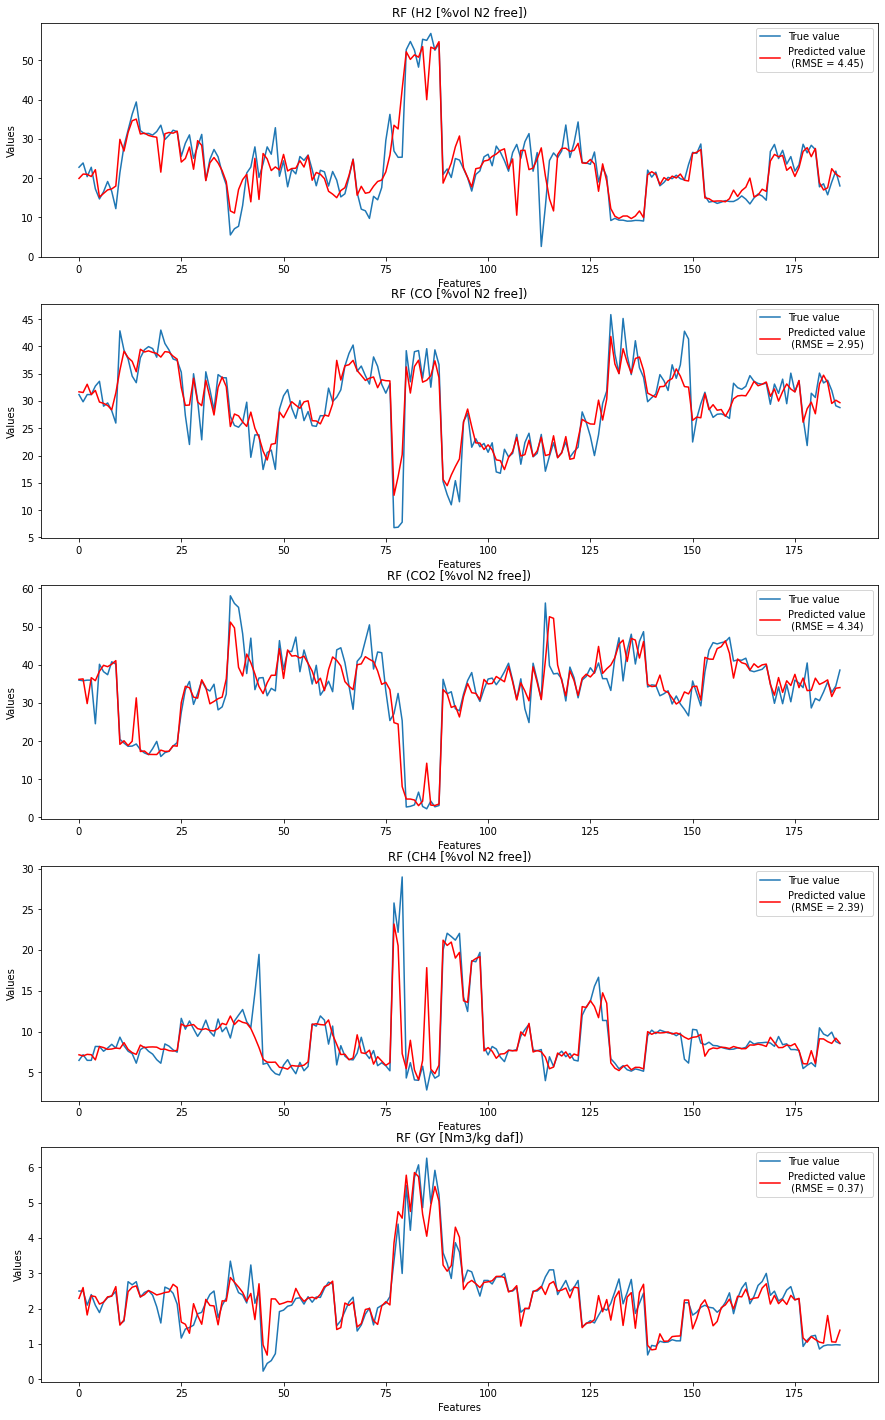

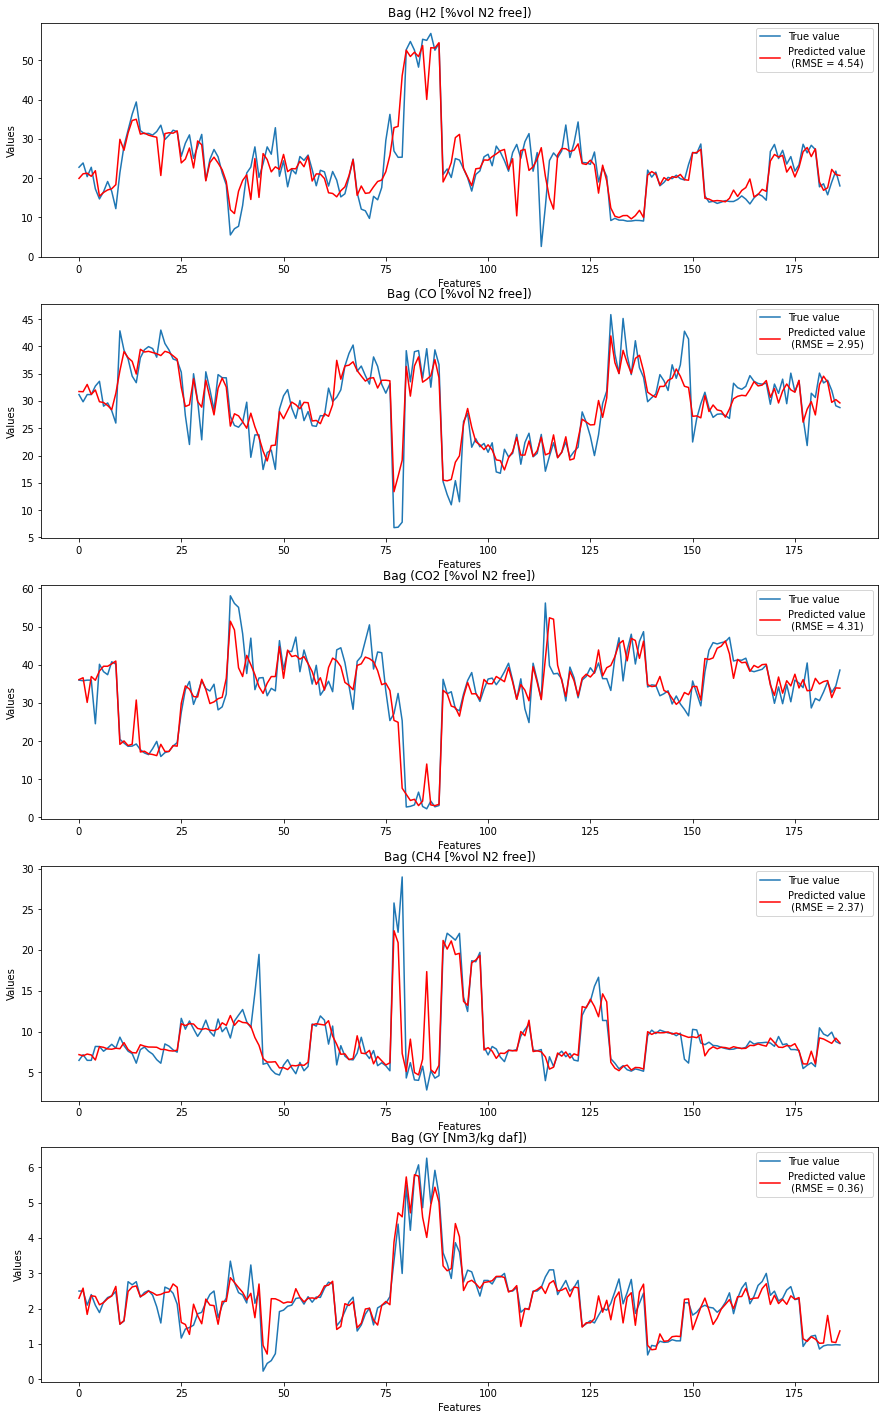

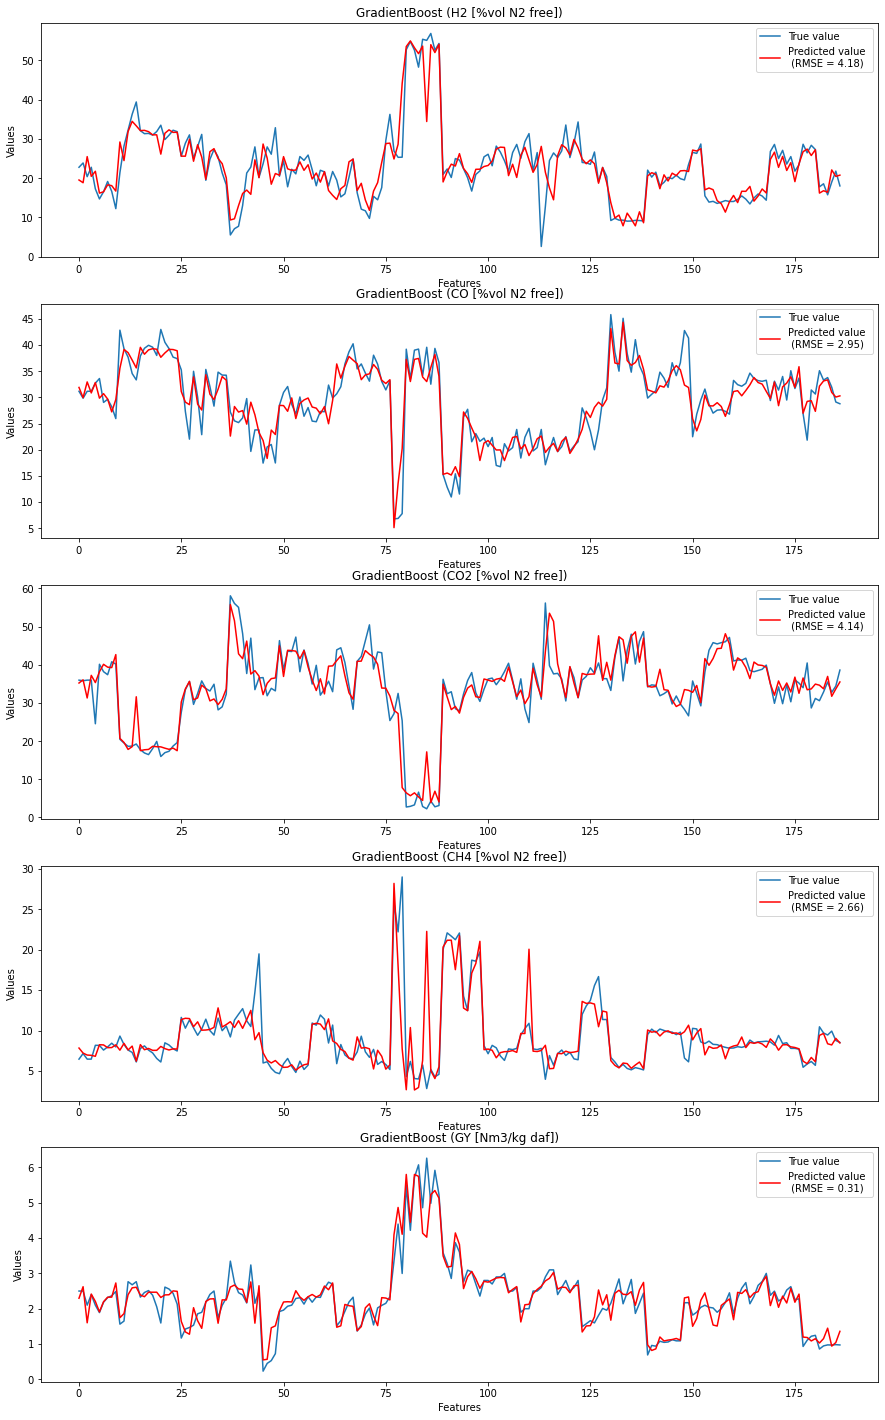

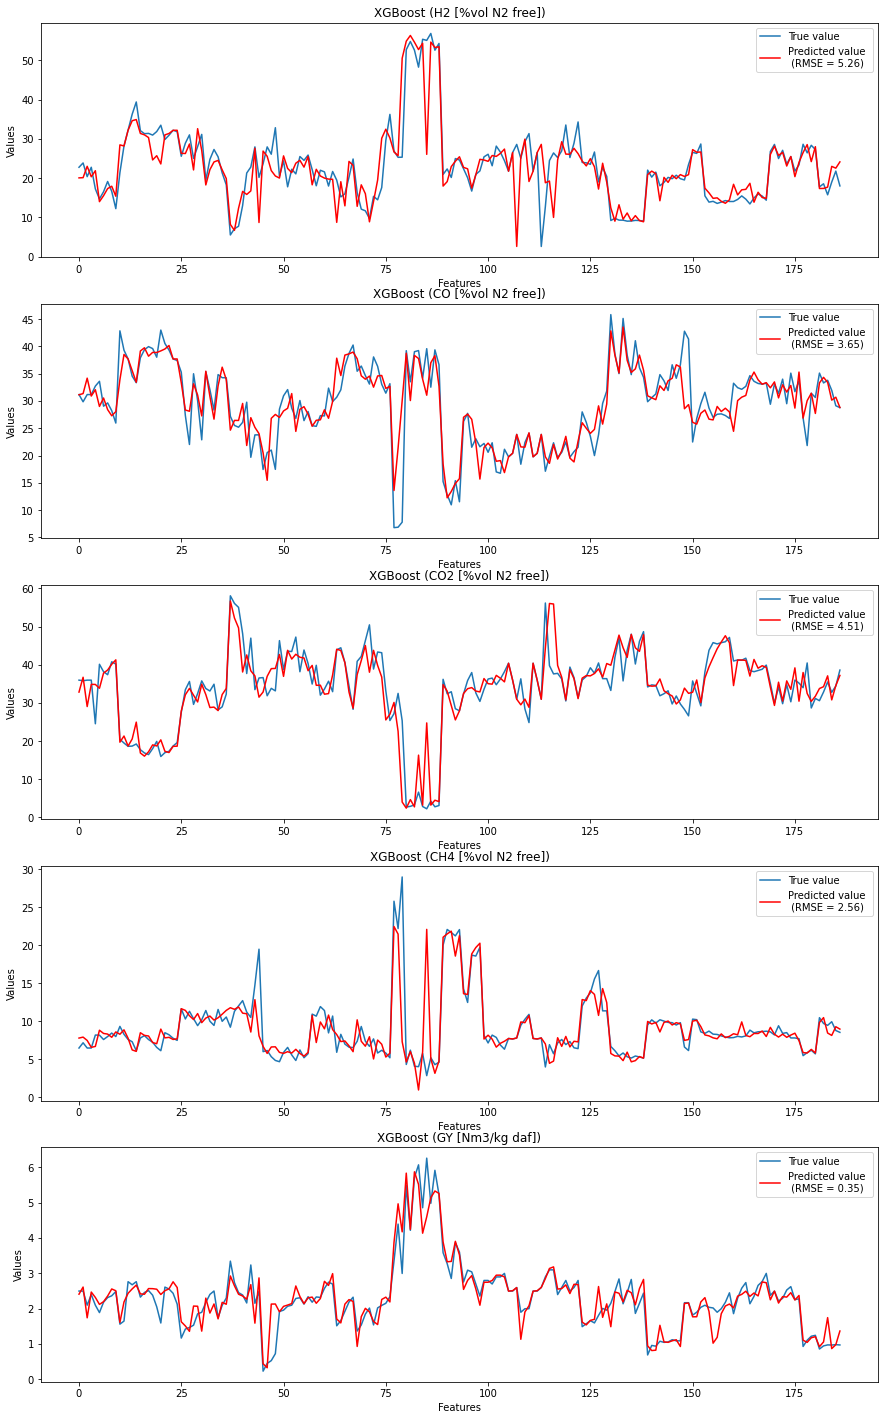

In [34]:
### Plot
for met in methods:
    plt.figure(figsize=(15, 25))
    for odx, out in enumerate(output_columns):
        plt.subplot(5, 1, odx +1)
        plt.plot(np.asarray(y)[:, odx], label='True value')
        plt.plot(np.asarray(prediction[met])[:, odx], 'r', label='Predicted value \n (RMSE = %.2f)' % error[met][odx])
        plt.xlabel("Features")
        plt.ylabel("Values")
        plt.title("%s (%s)" % (met, out))
        plt.legend()

    plt.savefig('Prediction_%s.pdf' % met)
#     plt.show()